In [1]:
using Distributions
using ProfileView

In [2]:
type Individual
    m::Int64
    p::Int64
    v_e::Float64
    mu::Float64
    mu_b::Float64
    mu_sigma::Float64
    y::Array{Float64, 1}
    b::Array{Int64, 2}
    x::Array{Float64, 1}
    z::Array{Float64, 1}
    
    Individual(m, p, v_e, mu, mu_b, mu_sigma) = new(2*m, p, v_e, mu, mu_b, mu_sigma)
end  

type Population
    n::Int64
    base_ind::Individual
    generation::Int64
    fitness::Array{Float64, 1}
    surface::Distributions.MvNormal{PDMats.PDMat,Array{Float64,1}}
    pop::Array{Individual, 1}
    Population(n, base_ind, generation) = new(n, base_ind, generation)
end

In [13]:
function Population(n::Int, ind::Individual, pop_array::Array{Individual, 1})
    new_pop = Population(n, ind, 0)
    new_pop.generation = 0
    new_pop.pop = pop_array
    new_pop
end

function RandomInd!(ind::Individual, y_mean::Float64 = 0.0, g_sigma::Float64 = ind.mu_sigma)
    ind.y = rand(Normal(y_mean, g_sigma), ind.m)
    ind.b = rand(Bernoulli(), ind.p, ind.m)
    ind.x = ind.b * ind.y
    ind.z = ind.x + rand(Normal(0, ind.v_e), ind.p)
end

function RandomInd(ind::Individual, y_mean::Float64 = 0.0, g_sigma::Float64 = ind.mu_sigma)
    new_ind = Individual(ind.m/2, ind.p, ind.v_e, ind.mu, ind.mu_b, ind.mu_sigma)
    RandomInd!(new_ind, y_mean, g_sigma)
    new_ind
end

function RandomPop!(pop::Population, y_mean::Float64 = 0.0, g_sigma::Float64 = ind.mu_sigma)
    pop.pop = Array(Individual, pop.n)
    pop.generation = 0
    for i = 1:pop.n
        pop.pop[i] = RandomInd(pop.base_ind, y_mean, g_sigma)
    end
    pop.fitness = zeros(Float64, pop.n)
end


import Base.getindex
import Base.copy

function getindex(pop::Population, i::Integer)
    getindex(pop.pop, i)
end

function getindex(pop::Population, s::UnitRange)
    Population(length(s), pop.base_ind, getindex(pop.pop, s))
end

function append!(pop::Population, ind::Individual)
    pop.pop = [pop.pop; ind]
    pop.n = length(pop.pop)
end

function append!(pop1::Population, pop2::Population)
    # COMPARE BASE IND!
    pop1.pop = [pop1.pop; pop2.pop]
    pop.n = length(pop1.pop)
end

function join(pop1::Population, pop2::Population)
    # COMPARE BASE IND!
    new_pop = Population(pop1.n + pop2.n, pop1.base_ind)
    new_pop.pop = [pop1.pop; pop2.pop]
    new_pop
end

function copy!(source::Population, sink::Population)
    sink.n = source.n
    sink.base_ind = source.base_ind
    sink.generation = source.generation
    sink.fitness = source.fitness
    sink.surface = source.surface
    sink.pop = source.pop
end

function copy(source::Population)
    new_pop = Population(source.n, source.base_ind, source.generation)
    copy!(source, new_pop)
    new_pop
end
    
function mutation!(ind::Individual, bin_y, bin_b)
    mutation_y = rand(bin_y)
    if(mutation_y > 0)
        d_uni_y = DiscreteUniform(1, ind.m)
        norm_sigma = Normal(0, ind.mu_sigma)
        for k = range(1, mutation_y)
            i = rand(d_uni_y)
            ind.y[i] = ind.y[i] + rand(norm_sigma)
        end
    end
    mutation_b = rand(bin_b)
    if(mutation_b > 0)
        d_uni_p = DiscreteUniform(1, ind.p)
        d_uni_m = DiscreteUniform(1, ind.m)
        for k = range(1, mutation_b)
            i = rand(d_uni_p)
            j = rand(d_uni_m)
            ind.b[i,j] = ind.b[i, j] == 1 ? 0 : 1
        end
    end
end

function mutation!(pop::Population)
    bin_y = Binomial(ind.m, ind.mu)
    bin_b = Binomial(ind.m * ind.p, ind.mu_b)
    for k = 1:pop.n
        mutation!(pop.pop[k], bin_y, bin_b)
    end
end

function fitness(ind::Individual, mv_norm)
    ind_fitness = pdf(mv_norm, ind.z)
    isnan(ind_fitness) ? 0.0 : ind_fitness
end

function fitness!(pop::Population)
    for k = range(1, pop.n)
        pop.fitness[k] = fitness(pop.pop[k], pop.surface)
    end
    total_fitness = sum(pop.fitness)
    if(total_fitness < 0.000000001)
        fill!(pop.fitness, 1./pop.n)
    else
        pop.fitness = pop.fitness / total_fitness
    end

end

function cross!(ind_1::Individual, ind_2::Individual, new_ind::Individual,
                d_uni, norm_e, alele_1::Array{Int64, 1}, alele_2::Array{Int64, 1})
    rand!(d_uni, alele_1)
    rand!(d_uni, alele_2)
    for locus = range(2, 2, 5)
        new_ind.y[   locus - 1] = ind_1.y[   (locus - 1) + alele_1[convert(Int64, locus/2)]]
        new_ind.y[   locus]     = ind_2.y[   (locus - 1) + alele_2[convert(Int64, locus/2)]]
        new_ind.b[:, locus - 1] = ind_1.b[:, (locus - 1) + alele_1[convert(Int64, locus/2)]]
        new_ind.b[:, locus]     = ind_2.b[:, (locus - 1) + alele_2[convert(Int64, locus/2)]]
    end
    new_ind.x = new_ind.b * new_ind.y
    new_ind.z = new_ind.x + rand(norm_e, new_ind.p)
end

function choose_mates!(pop::Population, mates::Array{Int64, 1})
    matings = rand(Multinomial(pop.n, pop.fitness), 1)
    l = 1
    for k = 1:pop.n
        if(matings[k] > 0)
            for(i = 1:matings[k])
                mates[l] = k
                l = l + 1
            end
        end
    end
    round(Int64, shuffle!(mates))
end

function next_generation!(pop::Population, holder_pop::Population, sires, dames, d_uni, norm_e, alele_1, alele_2; selective = true)
    if (selective)
        fitness!(pop)
    else
        fill!(pop.fitness, 1./pop.n)
    end
    mutation!(pop)
    choose_mates!(pop, sires)
    choose_mates!(pop, dames)
    for i in 1:pop.n
        cross!(pop[sires[i]], pop[dames[i]], holder_pop.pop[i], d_uni, norm_e, alele_1, alele_2)
    end
    holder_pop.generation = pop.generation + 1
    copy!(holder_pop, pop)
end 

function moments(pop::Population)
    ys = convert(Array{Float64, 2}, reshape([ind.y[i] for ind in pop.pop, i in 1:pop.base_ind.m], pop.n, pop.base_ind.m))
    xs = convert(Array{Float64, 2}, reshape([ind.x[i] for ind in pop.pop, i in 1:pop.base_ind.p], pop.n, pop.base_ind.p))
    zs = convert(Array{Float64, 2}, reshape([ind.z[i] for ind in pop.pop, i in 1:pop.base_ind.p], pop.n, pop.base_ind.p))
    mean_b = zeros(Float64, pop.base_ind.p, pop.base_ind.m)
    for i in 1:pop.n
        mean_b += pop[i].b
    end
    mean_y = squeeze(mean(ys, 1), 1)
    mean_x = squeeze(mean(xs, 1), 1)
    mean_z = squeeze(mean(zs, 1), 1)
    mean_b = mean_b / pop.n

    P = cov(zs)
    G = cov(xs)
    h2 = diag(G)./diag(P)
    corrG = cor(xs)
    corrP = cor(zs)

    Dict([("mean_y", mean_y), 
          ("mean_b", mean_b), 
          ("mean_x", mean_x),
          ("mean_z", mean_z), 
          ("P", P), 
          ("G", G), 
          ("h2", h2), 
          ("corrG", corrG),
          ("corrP", corrP)])
end

moments (generic function with 1 method)

In [14]:
function run_pop(gen_drift, gen_stab)
    global ind = Individual(500, 20, 0.8, 0.005, 0.001, 0.2)
    pop = Population(5000, ind, 0)
    RandomPop!(pop)
    theta = zeros(Float64, ind.p)
    omega = diagm(ones(Float64, ind.p))
    pop.surface = MvNormal(theta, omega)
    fitness!(pop)
    holder_pop = copy(pop)
    
    sires = zeros(Int64, pop.n)
    dames = zeros(Int64, pop.n)
    d_uni = DiscreteUniform(0, 1)
    norm_e  = Normal(0, pop.base_ind.v_e)
    alele_1 = zeros(Int64, Int64(pop.base_ind.m/2))
    alele_2 = zeros(Int64, Int64(pop.base_ind.m/2))
    
    for i = 1:gen_drift
        if(i % 100 == 0) 
            println("Drift Generation :", i)
        end
        next_generation!(pop, holder_pop, sires, dames, d_uni, norm_e, alele_1, alele_2, selective = false)
    end
    for i = 1:gen_stab
        if(i % 100 == 0) 
            println("Selective Generation :", i)
        end
        next_generation!(pop, holder_pop, sires, dames, d_uni, norm_e, alele_1, alele_2, selective = true)
    end
end

run_pop (generic function with 1 method)

In [15]:
run_pop(1, 1)
Profile.clear()
@profile run_pop(1, 1)
0

0

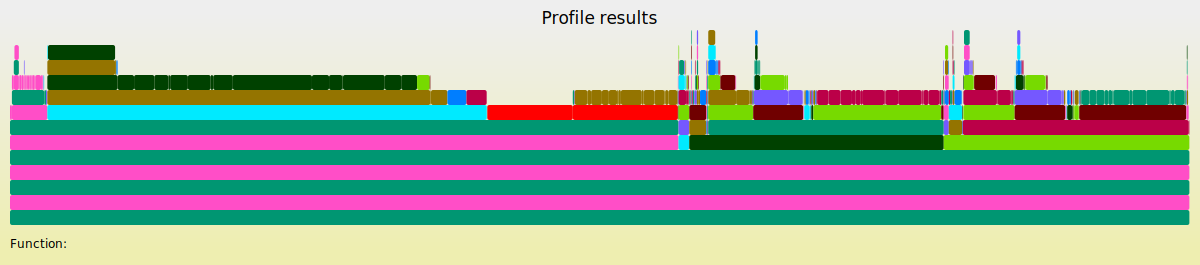

In [16]:
ProfileView.view()

In [17]:
run_pop(1, 1)
@time run_pop(1000, 2000)

Generation :100
Generation :200
Generation :300
Generation :400
Generation :500
Generation :600
Generation :700
Generation :800
Generation :900
Generation :1000
Selective Generation :100
Selective Generation :200
Selective Generation :300
Selective Generation :400
Selective Generation :500
Selective Generation :600
Selective Generation :700
Selective Generation :800
Selective Generation :900
Selective Generation :1000
Selective Generation :1100
Selective Generation :1200
Selective Generation :1300
Selective Generation :1400
Selective Generation :1500
Selective Generation :1600
Selective Generation :1700
Selective Generation :1800
Selective Generation :1900
Selective Generation :2000
1106.559594 seconds (425.23 M allocations: 50.863 GB, 0.72% gc time)
